In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re, string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [3]:
plt.rcParams['figure.figsize'] = [12, 10]

In [4]:
# setting dir
import os
os.chdir('/content/drive/MyDrive/Projects/Hacks/WWC Hackathon for Social Good/wwcode-hackathon-2022/data')

In [5]:
df = pd.read_csv("climate-news-db-all.csv")
print(df.shape)
df.info()

(9352, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9352 entries, 0 to 9351
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9352 non-null   int64  
 1   id              0 non-null      float64
 2   body            9352 non-null   object 
 3   headline        9318 non-null   object 
 4   article_name    8664 non-null   object 
 5   article_url     9352 non-null   object 
 6   date_published  9146 non-null   object 
 7   article_length  9352 non-null   int64  
 8   date_uploaded   9352 non-null   object 
 9   source          9352 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 730.8+ KB


In [6]:
df.drop(df.columns[[0, 1]], axis=1, inplace=True)

In [7]:
df.groupby('source')['body'].count()

source
aljazeera          480
atlantic           387
bbc                578
cnn                485
dailymail          502
dw                 379
economist          503
fox                410
guardian           842
independent        789
newshub            395
nytimes            630
nzherald           944
skyau              877
stuff              674
washington_post    477
Name: body, dtype: int64

## Preprocessing
- lowercase
- remove redundant phrases/patterns
  - bbc: at the end, there are some mentions of other headlines/videos
  - independent: “Please refresh the page or navigate to another page on the site to be automatically logged in Please refresh your browser to be logged in”, “Find your bookmarks in your Independent Premium section, under my profile”
  - dw: "Privacy Policy | Accessibility Statement | Legal notice | Contact | Mobile version"
- tokenize the words
- remove punctuations, symbols, hyperlinks,etc.
- lemmatization


In [29]:
df_cleaned = df.copy()

# convert text to lowercase
df_cleaned['body']= df_cleaned['body'].str.lower()

#independent news patterns
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'registration is a free.*?{{indy.fullname}}','', str(x), flags=re.DOTALL)) 
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'please refresh the page.*?browser to be logged in','', str(x), flags=re.DOTALL)) 
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'find your bookmarks.*?under my profile','', str(x), flags=re.DOTALL))

#bbc news patterns
df_cleaned['body'] = df_cleaned['body'].apply(lambda x: re.sub(r'mariupol defenders ignore russia.*?read about our approach to external linking.','', str(x), flags=re.DOTALL))

#dailymail patterns
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'share what you think.*?metro media group','', str(x), flags=re.DOTALL))
#not sure why r'by.*?view comments' doesn't work

#dw
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'privacy policy \|.*?mobile version','', str(x), flags=re.DOTALL))

#economist
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'your browser.*?<audio> element','', str(x), flags=re.DOTALL))
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'copyright.*?rights reserved.','', str(x), flags=re.DOTALL))

#nytimes
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'as a subscriber.*?read what you share','', str(x), flags=re.DOTALL))
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'to give each month.*?read what you share','', str(x), flags=re.DOTALL))

#stuff
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: str(x).replace('stuff limited',''))

#washington_post
df_cleaned['body'] =  df_cleaned['body'].apply(lambda x: re.sub(r'this article was published.*?ago','', str(x), flags=re.DOTALL))

In [31]:
# checks on the news text
source = df_cleaned['source'] == 'bbc'
df_cleaned[source][['body']][12:14]

,body
879,"by mark kinver environment reporter, bbc news ..."
880,by roger harrabin bbc environment analyst we k...


In [39]:
def remove_noise(tweet_tokens, stop_words = ()):
  """
  This function removes noise such as hyperlinks, special symbols, and punctuation.
  It also applies lemmatization given the tag of each token.
  
  """
  cleaned_tokens = []

  for token, tag in pos_tag(tweet_tokens):
      # remove hyperlinks
      token = re.sub('https?:\/\/[^\s\n\r]+','',token)
      # remove symbols and punctuations
      token = re.sub("(?:[\$\-_@\.&+#%^=?`~]|[!*\(\),\[\]{}\\\/|;:\'\"<>]|)",'',token)
      # or remove all non alpha-numeric? 
      token = re.sub("[^a-zA-Z0-9 -]","", token)
      if tag.startswith("NN"):
          pos = 'n'
      elif tag.startswith('VB'):
          pos = 'v'
      else:
          pos = 'a'

      lemmatizer = WordNetLemmatizer()
      token = lemmatizer.lemmatize(token, pos)

      if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
          cleaned_tokens.append(token.lower())
  return cleaned_tokens

In [40]:
#add all the news into a list
news_list = [news for news in df_cleaned['body']]

# tokenize words
tokenized_text = []
for text in news_list:
  tokenized_words = word_tokenize(text)  
  tokenized_text.append(tokenized_words)

In [71]:
# set stopwords
stop_words = stopwords.words('english')
# checks on remove_noise function
print(news_list[100])
print(tokenized_text[100])
print(remove_noise(tokenized_text[100], stop_words))

global day of student protests aims to prompt world leaders into action on climate change. young people around the world are skipping school on friday to march through the streets, kicking off a global day of student protests aiming to drive world leaders into action on climate change . classrooms in capitals from lagos to london are expected to be empty, as the ambitious organisers of the international student strike hoped to stage 1,000 demonstrations in more than 100 countries. george bond, a student protester in london who travelled several hours to demonstrate outside the british parliament, told al jazeera it was “imperative that young people are able to break the cycle of inaction that directly threatens the security of their future on this planet”. “there is not sufficient and effective policy to keep the uk’s carbon targets below where they need to be,” he said. “and equally they are not following the advice of the [united nations intergovernmental panel on climate change] ipc

In [48]:
cleaned_tokens = []
for news in tokenized_text:
  cleaned_tokens.append(remove_noise(news,stop_words))
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [49]:
# add cleaned tokens to df
df_cleaned['cleaned_tokens'] = cleaned_tokens
print(df_cleaned.columns)
print(df_cleaned.shape)

Index(['body', 'headline', 'article_name', 'article_url', 'date_published',
       'article_length', 'date_uploaded', 'source', 'cleaned_tokens'],
      dtype='object')
(9352, 9)


In [51]:
#df_cleaned.to_csv('news_cleaned_tokens.csv', index=False)

# Text Analysis
- word cloud, word frequencies, tfidf
- ngrams
- sentiment analysis

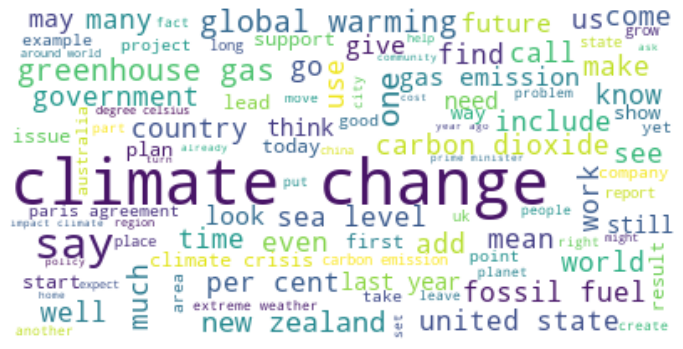

In [52]:
cleaned_texts = [" ".join(text) for text in cleaned_tokens]
full_cleaned_text = " ".join(cleaned_texts)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white', max_words=100).generate(full_cleaned_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
all_cleaned_words = []
for news in cleaned_tokens:
  for word in news:
    all_cleaned_words.append(word)

# get freq of words
freq_dist = FreqDist(all_cleaned_words)
freq_dist_df = pd.DataFrame(freq_dist.most_common(100), columns=['Word', 'Count'])

In [54]:
freq_dist_df

,Word,Count
0,climate,86504
1,change,60475
2,say,58352
3,year,27960
4,emission,24368
...,...,...
95,extreme,6212
96,planet,6154
97,mean,6129
98,event,6108


In [65]:
# creating bigrams 
# min_df: words that appear in at least 300 docs
corpus = cleaned_texts
vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=300)
bigrams = vect.fit_transform(corpus)
print(bigrams.shape)

(9352, 292)


In [66]:
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names_out())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False)
bigram_frequency

,bigram,frequency
54,climate change,46355
131,greenhouse gas,7244
129,global warming,7093
177,new zealand,6238
118,fossil fuel,5603
...,...,...
114,find way,334
19,atmospheric administration,327
5,21st century,326
89,drought flood,320


In [68]:
# creating trigrams 
vect = CountVectorizer(stop_words=stop_words, ngram_range=(3,3), min_df=200)
trigrams = vect.fit_transform(corpus)
print(trigrams.shape)

(9352, 116)


In [69]:
trigram_df = pd.DataFrame(trigrams.toarray(), columns=vect.get_feature_names_out())
trigram_frequency = pd.DataFrame(trigram_df.sum(axis=0)).reset_index()
trigram_frequency.columns = ['trigram', 'frequency']
trigram_frequency = trigram_frequency.sort_values(by='frequency', ascending=False)
trigram_frequency

,trigram,frequency
62,greenhouse gas emission,3395
65,impact climate change,1668
99,sea level rise,1661
48,effect climate change,1413
79,panel climate change,1273
...,...,...
94,response climate change,223
112,un intergovernmental panel,221
30,climate change increase,219
68,issue climate change,212


In [70]:
# n_grams = 5
vect = CountVectorizer(stop_words=stop_words, ngram_range=(5,5), min_df=25)
ngrams = vect.fit_transform(corpus)
print(ngrams.shape)

ngram_df = pd.DataFrame(ngrams.toarray(), columns=vect.get_feature_names_out())
ngram_frequency = pd.DataFrame(ngram_df.sum(axis=0)).reset_index()
ngram_frequency.columns = ['ngram', 'frequency']
ngram_frequency = ngram_frequency.sort_values(by='frequency', ascending=False)
ngram_frequency

(9352, 642)


,ngram,frequency
321,intergovernmental panel climate change ipcc,517
525,september 1843 take part severe,496
526,severe contest intelligence press forward,496
535,since september 1843 take part,496
457,publish since september 1843 take,496
...,...,...
201,effort reduce greenhouse gas emission,25
214,environment deliver every thursday learn,25
579,thursday learn know global warming,25
567,teenage climate activist greta thunberg,25
